It is possible that there are data mislabeled as D. melanogaster that actually are from other sources. Some of this could be inferred based on the percentages uniquely mapping #43, but another way is to try mapping to other references. If a sample maps mostly to human or mouse it would be save to say that the sample label was either switched, or samples were mixed and not properly separated. In these cases it would be best to ignore samples with high amounts of contamination from other species because it would take too much effort to determine if this was intended.

These data can also be used to look for rRNA contamination. If a sample has a large amount of rRNA, then it would suggest that it was RNA-seq from either total RNA or a bad polyA selection/ribo depletion. Either way, it does indicate that the sample is indeed RNA-seq, but may have some issues. I don't think these samples need to be filtered, but they should be flagged and this flag can be used as a feature for clustering.

Questions and Tasks

- [ ] How many samples show contamination from other species?
- [ ] How many samples show rRNA contamination?
- [ ] Create table flagging samples

In [2]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')
mpl.rc("figure", figsize=(8, 6))

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-10-03 
Git hash: 8d159e54c44e4bc728ec920f31b6a31e6c30d842


In [3]:
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
remap = db['remap']


In [4]:
remap.find_one({'runs.pre_aln_workflow.fastq_screen': {'$exists': 1}})

{'_id': 'SRX2581987',
 'bioproject': 'PRJNA357269',
 'contacts': [{'email': 'marcelorivas@gmail.com',
   'first_name': 'Marcelo',
   'last_name': 'Rivas'}],
 'papers': [],
 'runs': [{'avgReadLen': {'R1': 142.97425121403273, 'R2': 143.68871950516282},
   'libsize': {'R1': 17428278, 'R2': 17428278},
   'md5': {'R1': '1ef1ee5447afb2a8852f52224abf3940',
    'R2': '144600f42c19d3c2101b968d9f834567'},
   'pre_aln_flags': ['PE', 'unstranded', 'complete'],
   'pre_aln_workflow': {'fastq_screen': {'adapters': {'multiple_hits_multiple_libraries_count': 86.0,
      'multiple_hits_multiple_libraries_percent': 0.09,
      'multiple_hits_one_library_count': 0.0,
      'multiple_hits_one_library_percent': 0.0,
      'one_hit_multiple_libraries_count': 1.0,
      'one_hit_multiple_libraries_percent': 0.0,
      'one_hit_one_library_count': 0.0,
      'one_hit_one_library_percent': 0.0,
      'reads_processed_count': 100162.0,
      'unmapped_count': 100075.0,
      'unmapped_percent': 99.91},
     'dm

In [5]:
# Pull out the fastq screen information and make a giant table
def useful_bits(record):
    df = pd.DataFrame(record['fastq_screen'])
    df.index.name = 'metric'
    df['srx'] = record['srx']
    df['srr'] = record['srr']
    return df.reset_index().set_index(['srx', 'srr', 'metric'])

agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_flags': 'complete',
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$runs.srr',
            'fastq_screen': '$runs.pre_aln_workflow.fastq_screen'
        }
    },
])

_dfs = []
for record in agg:
    _dfs.append(useful_bits(record))

data = pd.concat(_dfs)
del _dfs

# sort index
data.sort_index(inplace=True)
data.head()

adapters  \
srx       srr       metric                                               
DRX000774 DRR001177 multiple_hits_multiple_libraries_count         1.0   
                    multiple_hits_multiple_libraries_percent       0.0   
                    multiple_hits_one_library_count                0.0   
                    multiple_hits_one_library_percent              0.0   
                    one_hit_multiple_libraries_count               0.0   

                                                                   dm6  ecoli  \
srx       srr       metric                                                      
DRX000774 DRR001177 multiple_hits_multiple_libraries_count    16376.00    0.0   
                    multiple_hits_multiple_libraries_percent     16.40    0.0   
                    multiple_hits_one_library_count             125.00    0.0   
                    multiple_hits_one_library_percent             0.13    0.0   
                    one_hit_multiple_libraries_count             10.00    0.0   

                                                              ercc  hg19  \
srx       srr       metric                                                 
DRX000774 DRR001177 multiple_hits_multiple_libraries_count     1.0   3.0   
                    multiple_hits_multiple_libraries_percent   0.0   0.0   
                    multiple_hits_one_library_count            0.0   3.0   
                    multiple_hits_one_library_percent          0.0   0.0   
                    one_hit_multiple_libraries_count           0.0   1.0   

                                                              phix      rRNA  \
srx       srr       metric                                                     
DRX000774 DRR001177 multiple_hits_multiple_libraries_count     0.0  16364.00   
                    multiple_hits_multiple_libraries_percent   0.0     16.38   
                    multiple_hits_one_library_count            0.0      2.00   
                    multiple_hits_one_library_percent          0.0      0.00   
                    one_hit_multiple_libraries_count           0.0     19.00   

                                                              wolbachia  yeast  
srx       srr       metric                                                      
DRX000774 DRR001177 multiple_hits_multiple_libraries_count          0.0    2.0  
                    multiple_hits_multiple_libraries_percent        0.0    0.0  
                    multiple_hits_one_library_count                 0.0    2.0  
                    multiple_hits_one_library_percent               0.0    0.0  
                    one_hit_multiple_libraries_count                0.0    0.0

There are several ways to look at these kind of data. We can consider only reads that map uniquely to a specific reference, or we can consider reads that map to multiple references.

# One Hit One Library

One hit one library are reads that align to only one location in one reference. I expect that the majority of reads will map to the D. melanogaster reference because that is how they are annotated. We see that there are some samples will a large fraction of human and yeast. We also see some signal from the ERCC controls. 

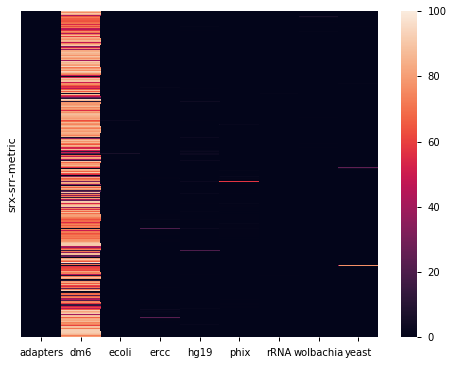

In [6]:
# Plot heatmap of one hit one species
singles = data.loc[(slice(None), slice(None), 'one_hit_one_library_percent'), :]
sns.heatmap(singles, yticklabels=False)

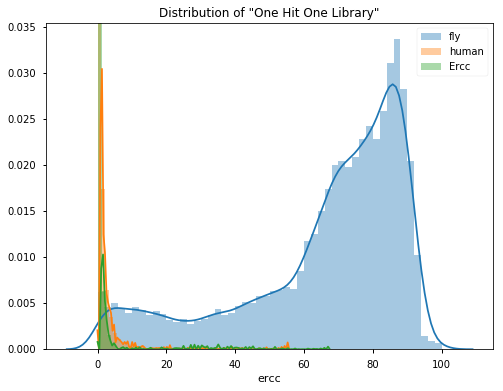

In [7]:
# Plot distirbution of major categories
sns.distplot(singles.dm6, label='fly')
sns.distplot(singles.hg19, label='human')
sns.distplot(singles.ercc, label='Ercc')
plt.legend()
plt.title('Distribution of "One Hit One Library"');

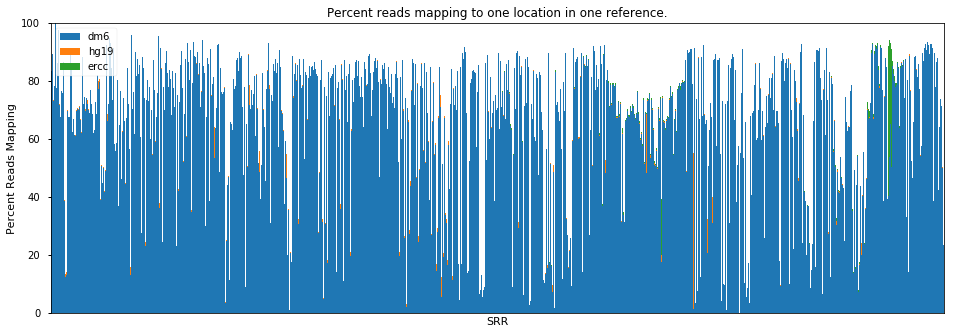

In [26]:
# Plot stacked bars showing percents of reads mapping.
fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/3))
singles[['dm6', 'hg19', 'ercc']].sort_index().plot.bar(stacked=True, ax=ax, linewidth=0, width=1)
ax.set_title('Percent reads mapping to one location in one reference.')
ax.set_xlabel('SRR')
ax.set_ylabel('Percent Reads Mapping')
ax.set_xticklabels([]);
ax.set_xticks([]);
ax.set_ylim(0, 100);

In [39]:
# For each sample figure out the major contributing source
majority = singles.apply(lambda x: x.argmax(), axis=1)

In [40]:
# output counts for number of samples where a contaminant was the major source.
_df = majority.value_counts()
_df['total'] = _df.sum()
_df = _df.map(lambda x: '{:,}'.format(x)).to_frame()
_df.columns = ['Number of Samples']
_df

,Number of Samples
dm6,"21,848"
yeast,204
hg19,50
ercc,36
adapters,17
rRNA,11
phix,11
ecoli,9
wolbachia,4
total,"22,190"


In [41]:
# what do rRNA look like?
singles[majority == 'rRNA']

adapters   dm6  ecoli  ercc  \
srx       srr        metric                                                     
DRX000775 DRR001178  one_hit_one_library_percent       0.0  0.10    0.0   0.0   
ERX521758 ERR562736  one_hit_one_library_percent       0.0  1.69    0.0   0.0   
SRX008031 SRR023400  one_hit_one_library_percent       0.0  0.06    0.0   0.0   
SRX008034 SRR023399  one_hit_one_library_percent       0.0  0.07    0.0   0.0   
SRX008036 SRR023402  one_hit_one_library_percent       0.0  0.08    0.0   0.0   
SRX137002 SRR458497  one_hit_one_library_percent       0.0  0.13    0.0   0.0   
SRX137003 SRR458496  one_hit_one_library_percent       0.0  0.13    0.0   0.0   
SRX332205 SRR950144  one_hit_one_library_percent       0.0  1.76    0.0   0.0   
          SRR950145  one_hit_one_library_percent       0.0  1.98    0.0   0.0   
          SRR950146  one_hit_one_library_percent       0.0  1.99    0.0   0.0   
SRX716411 SRR1592123 one_hit_one_library_percent       0.0  0.06    0.0   0.0   

                                                  hg19  phix  rRNA  wolbachia  \
srx       srr        metric                                                     
DRX000775 DRR001178  one_hit_one_library_percent  0.00  0.00  0.14        0.0   
ERX521758 ERR562736  one_hit_one_library_percent  0.01  0.13  2.69        0.0   
SRX008031 SRR023400  one_hit_one_library_percent  0.00  0.00  0.10        0.0   
SRX008034 SRR023399  one_hit_one_library_percent  0.00  0.00  0.12        0.0   
SRX008036 SRR023402  one_hit_one_library_percent  0.01  0.00  0.11        0.0   
SRX137002 SRR458497  one_hit_one_library_percent  0.01  0.00  1.24        0.0   
SRX137003 SRR458496  one_hit_one_library_percent  0.01  0.00  1.27        0.0   
SRX332205 SRR950144  one_hit_one_library_percent  0.04  0.00  1.89        0.0   
          SRR950145  one_hit_one_library_percent  0.04  0.00  2.06        0.0   
          SRR950146  one_hit_one_library_percent  0.04  0.00  2.41        0.0   
SRX716411 SRR1592123 one_hit_one_library_percent  0.05  0.00  0.08        0.0   

                                                  yeast  
srx       srr        metric                              
DRX000775 DRR001178  one_hit_one_library_percent   0.00  
ERX521758 ERR562736  one_hit_one_library_percent   0.20  
SRX008031 SRR023400  one_hit_one_library_percent   0.00  
SRX008034 SRR023399  one_hit_one_library_percent   0.00  
SRX008036 SRR023402  one_hit_one_library_percent   0.00  
SRX137002 SRR458497  one_hit_one_library_percent   0.18  
SRX137003 SRR458496  one_hit_one_library_percent   0.16  
SRX332205 SRR950144  one_hit_one_library_percent   0.00  
          SRR950145  one_hit_one_library_percent   0.00  
          SRR950146  one_hit_one_library_percent   0.00  
SRX716411 SRR1592123 one_hit_one_library_percent   0.00

In [42]:
# How many samples have 1% of reads aligning to another major source?
contaminant = (singles.filter(regex='[^(dm6 | rRNA | adapters | ercc)]') >= 1).any(axis=1)
num_samples_w_contaminant = contaminant.sum()

print('There were {:,} SRRs that showed at least '
      '1% of reads coming from another source.'.format(num_samples_w_contaminant))

There were 1,995 SRRs that showed at least 1% of reads coming from another source.


# One Hit Multi Libraries

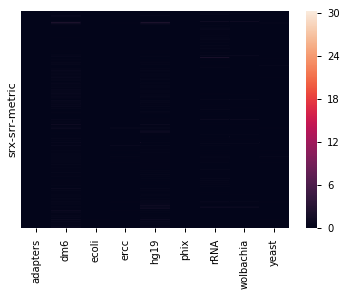

In [43]:
# Plot heatmap of multi hit multi species
multi = data.loc[(slice(None), slice(None), 'one_hit_multiple_libraries_percent'), :]
sns.heatmap(multi, yticklabels=False)

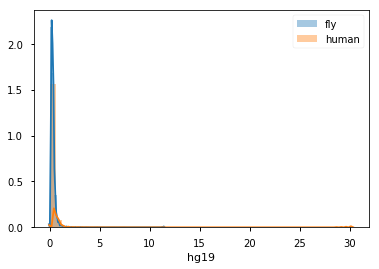

In [44]:
# Plot distirbution of major categories
sns.distplot(multi.dm6, label='fly')
sns.distplot(multi.hg19, label='human')
plt.legend()

In [45]:
# For each sample figure out the major contributing source
majority = multi.apply(lambda x: x.argmax(), axis=1)

In [46]:
# output counts for number of samples where a contaminant was the major source.
_df = majority.value_counts()
_df['total'] = _df.sum()
_df = _df.map(lambda x: '{:,}'.format(x)).to_frame()
_df.columns = ['Number of Samples']
_df

,Number of Samples
dm6,"12,665"
rRNA,"5,528"
hg19,"3,414"
yeast,394
adapters,137
ercc,48
wolbachia,4
total,"22,190"


In [47]:
# what do rRNA look like?
multi[majority == 'rRNA'].head()

,,,adapters,dm6,ecoli,ercc,hg19,phix,rRNA,wolbachia,yeast
srx,srr,metric,,,,,,,,,
DRX000774,DRR001177,one_hit_multiple_libraries_percent,0.0,0.01,0.0,0.0,0.00,0.0,0.02,0.0,0.00
DRX000775,DRR001178,one_hit_multiple_libraries_percent,0.0,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.00
DRX000999,DRR001445,one_hit_multiple_libraries_percent,0.0,0.23,0.0,0.0,0.12,0.0,0.29,0.0,0.05
DRX001000,DRR001446,one_hit_multiple_libraries_percent,0.0,0.17,0.0,0.0,0.11,0.0,0.26,0.0,0.02
DRX001001,DRR001447,one_hit_multiple_libraries_percent,0.0,0.12,0.0,0.0,0.18,0.0,0.28,0.0,0.09


In [48]:
# How many samples have 1% of reads aligning to another major source?
contaminant = (multi.filter(regex='[^(dm6 | rRNA | adapters | ercc)]') >= 1).any(axis=1)
num_samples_w_contaminant = contaminant.sum()

print('There were {:,} SRRs that showed at least '
      '1% of reads coming from another source.'.format(num_samples_w_contaminant))

There were 690 SRRs that showed at least 1% of reads coming from another source.


In [49]:
# look at samples with the higest value for one hit multi libraries.
multi[multi.index.isin(multi.idxmax().values)]

,,,adapters,dm6,ecoli,ercc,hg19,phix,rRNA,wolbachia,yeast
srx,srr,metric,,,,,,,,,
DRX000774,DRR001177,one_hit_multiple_libraries_percent,0.00,0.01,0.00,0.00,0.00,0.0,0.02,0.00,0.00
ERX249571,ERR297217,one_hit_multiple_libraries_percent,0.00,1.64,1.69,0.03,2.45,0.0,0.27,0.33,1.09
ERX364958,ERR394877,one_hit_multiple_libraries_percent,0.00,0.17,0.00,0.00,30.29,0.0,0.08,0.00,0.01
SRX1749708,SRR3487708,one_hit_multiple_libraries_percent,0.09,0.38,0.00,0.33,0.19,0.0,0.51,0.00,0.39
SRX2163330,SRR4242450,one_hit_multiple_libraries_percent,0.02,0.09,0.01,0.00,0.06,0.0,0.06,0.00,9.61
SRX2276826,SRR4463852,one_hit_multiple_libraries_percent,0.00,0.15,0.00,0.00,0.08,0.0,29.10,29.08,0.01
SRX2556774,SRR5251040,one_hit_multiple_libraries_percent,0.01,11.42,0.01,0.83,5.36,0.0,1.66,0.00,2.49
SRX313713,SRR919324,one_hit_multiple_libraries_percent,0.06,0.69,0.00,12.96,0.70,0.0,0.37,0.01,0.59


In [56]:
# The SRX255677* were all done by the same group (s2 cells) polyA-clickseq
multi.dm6.sort_values(ascending=False).head(20).to_frame()

,,,dm6
srx,srr,metric,
SRX2556774,SRR5251040,one_hit_multiple_libraries_percent,11.42
SRX2556771,SRR5251037,one_hit_multiple_libraries_percent,10.08
SRX2556773,SRR5251039,one_hit_multiple_libraries_percent,9.87
SRX2556770,SRR5251036,one_hit_multiple_libraries_percent,9.64
SRX2556775,SRR5251041,one_hit_multiple_libraries_percent,9.54
SRX2556772,SRR5251038,one_hit_multiple_libraries_percent,9.03
SRX456470,SRR1151373,one_hit_multiple_libraries_percent,8.97
SRX456471,SRR1151374,one_hit_multiple_libraries_percent,8.73
SRX272770,SRR836132,one_hit_multiple_libraries_percent,8.51


# Multi Hit Multi Library

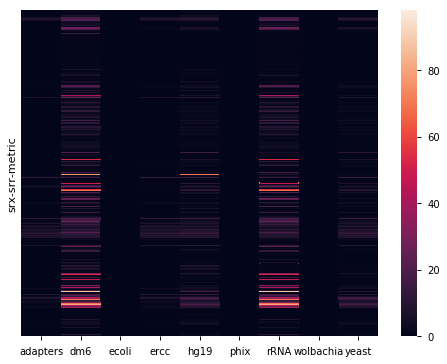

In [137]:
# Plot heatmap of multi hit multi species
multiMulti = data.loc[(slice(None), slice(None), 'multiple_hits_multiple_libraries_percent'), :]
sns.heatmap(multiMulti, yticklabels=False)

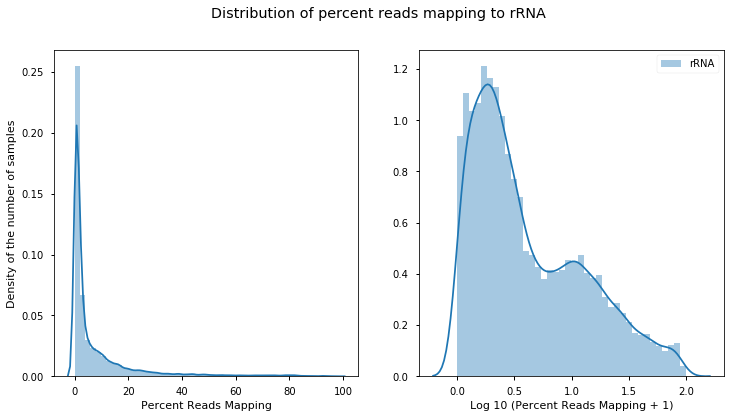

In [138]:
# Plot distirbution of major categories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/2))
sns.distplot(multiMulti.rRNA, label='rRNA', ax=ax1)
sns.distplot(np.log10(multiMulti.rRNA + 1), label='rRNA', ax=ax2)
ax2.legend()
ax1.set_xlabel('Percent Reads Mapping')
ax2.set_xlabel('Log 10 (Percent Reads Mapping + 1)')
ax1.set_ylabel('Density of the number of samples')
plt.suptitle('Distribution of percent reads mapping to rRNA');

In [60]:
# For each sample figure out the major contributing source
majority = multiMulti.apply(lambda x: x.argmax(), axis=1)

In [61]:
# output counts for number of samples where a contaminant was the major source.
_df = majority.value_counts()
_df['total'] = _df.sum()
_df = _df.map(lambda x: '{:,}'.format(x)).to_frame()
_df.columns = ['Number of Samples']
_df

,Number of Samples
dm6,"21,356"
hg19,375
yeast,323
adapters,79
ecoli,33
rRNA,23
wolbachia,1
total,"22,190"


In [73]:
# what do rRNA look like?
multiOne[majority == 'rRNA']

,,,adapters,dm6,ecoli,ercc,hg19,phix,rRNA,wolbachia,yeast
srx,srr,metric,,,,,,,,,
SRX033131,SRR077420,multiple_hits_one_library_percent,0.0,0.36,0.00,0.0,0.06,0.0,0.46,0.0,0.00
SRX033132,SRR077419,multiple_hits_one_library_percent,0.0,0.32,0.00,0.0,0.04,0.0,0.51,0.0,0.00
SRX219317,SRR652414,multiple_hits_one_library_percent,0.0,0.03,0.00,0.0,0.01,0.0,0.04,0.0,0.00
SRX219320,SRR652417,multiple_hits_one_library_percent,0.0,0.01,0.00,0.0,0.04,0.0,0.06,0.0,0.00
SRX219321,SRR652418,multiple_hits_one_library_percent,0.0,0.03,0.00,0.0,0.01,0.0,0.12,0.0,0.00
SRX219323,SRR652420,multiple_hits_one_library_percent,0.0,0.02,0.00,0.0,0.02,0.0,0.04,0.0,0.00
SRX219328,SRR652425,multiple_hits_one_library_percent,0.0,0.04,0.00,0.0,0.01,0.0,0.05,0.0,0.01
SRX219331,SRR652428,multiple_hits_one_library_percent,0.0,0.02,0.00,0.0,0.02,0.0,0.07,0.0,0.00
SRX219332,SRR652429,multiple_hits_one_library_percent,0.0,0.02,0.00,0.0,0.03,0.0,0.04,0.0,0.00


In [94]:
mask = data.index.get_level_values(2).str.contains('percent') & \
    ~data.index.get_level_values(2).str.contains('unmapped')
data[mask].sort_values('rRNA', ascending=False)

,,,adapters,dm6,ecoli,ercc,hg19,phix,rRNA,wolbachia,yeast
srx,srr,metric,,,,,,,,,
SRX1492032,SRR3033314,multiple_hits_multiple_libraries_percent,0.0,98.06,0.00,0.00,23.22,0.00,98.06,0.0,12.11
SRX1321800,SRR2599613,multiple_hits_multiple_libraries_percent,0.0,97.36,0.00,0.00,17.35,0.00,96.84,0.0,13.85
SRX1492036,SRR3033318,multiple_hits_multiple_libraries_percent,0.0,96.17,0.00,0.00,19.01,0.00,96.16,0.0,11.01
SRX763987,SRR1657539,multiple_hits_multiple_libraries_percent,0.0,95.48,0.01,0.00,0.37,0.00,95.28,0.0,0.22
SRX190816,SRR578723,multiple_hits_multiple_libraries_percent,0.0,95.26,0.00,0.00,19.77,0.00,95.24,0.0,16.50
SRX385702,SRR1041343,multiple_hits_multiple_libraries_percent,0.0,95.05,0.00,0.00,17.39,0.00,94.98,0.0,14.25
SRX190815,SRR578722,multiple_hits_multiple_libraries_percent,0.0,94.65,0.01,0.00,21.53,0.00,94.63,0.0,16.45
SRX190813,SRR578720,multiple_hits_multiple_libraries_percent,0.0,94.49,0.01,0.00,21.80,0.00,94.47,0.0,16.84
SRX190817,SRR578724,multiple_hits_multiple_libraries_percent,0.0,94.44,0.01,0.00,22.13,0.00,94.41,0.0,17.01
